Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/maxudong1993/deep-image-prior.git
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 360 (delta 31), reused 46 (delta 15), pack-reused 289
Receiving objects: 100% (360/360), 42.12 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [2]:
!ls ./

activation_maximization.ipynb  mydenoising.ipynb
data			       mydenoisingSensorGain.ipynb
deep-image-prior	       mydenoisingTest.ipynb
denoising.ipynb		       README.md
Dockerfile		       restoration.ipynb
environment.yml		       sample_data
feature_inversion.ipynb        sr_prior_effect.ipynb
flash-no-flash.ipynb	       super-resolution_eval_script.py
inpainting.ipynb	       super-resolution.ipynb
LICENSE			       utils
models


# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

#?enable best algorithm for hardware  
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [4]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

## US-MRI fusion
fname_us = 'data/denoising/us_mod.png'
fname_mr = 'data/denoising/mri_mod.png'
fname_us, fname_mr = samesize_images(fname_us, fname_mr) #BiCubic magtify
print(fname_us)
print(fname_mr)
# print(inspect.getsourcefile(pil_to_np))


data/denoising/us_mod.png
data/denoising/mri_mod_samesize.png


In [5]:
img = Image.open(fname_mr)
# img_np = np.array(img)
#img.crop([1,1,32,32]) cropfrom (1,1) to (32,32)
print(pil_to_np(img).shape)

# display(img)
# plt.imshow(np.asarray(img))
# img.show()

(1, 600, 600)


# **Load MRI and US**

[[0.977657   0.977657   0.977657   ... 0.977657   0.977657   0.977657  ]
 [0.977657   0.977657   0.977657   ... 0.95901003 0.95901003 0.95901003]
 [0.95901003 0.95901003 0.95901003 ... 0.95901003 0.95901003 0.95901003]
 ...
 [0.9980685  0.9980685  0.9980685  ... 0.9980685  0.9980685  0.9980685 ]
 [0.9980685  0.9980685  0.9980685  ... 0.99817079 0.99817079 0.99817079]
 [0.99817079 0.99817079 0.99817079 ... 0.99817079 0.99817079 0.99817079]]
[[0.21020654 0.21020654 0.21020654 ... 0.21020654 0.21020654 0.21020654]
 [0.21020654 0.21020654 0.21020654 ... 0.28337213 0.28337213 0.28337213]
 [0.28337213 0.28337213 0.28337213 ... 0.28337213 0.28337213 0.28337213]
 ...
 [0.06212308 0.06212308 0.06212308 ... 0.06212308 0.06212308 0.06212308]
 [0.06212308 0.06212308 0.06212308 ... 0.06045719 0.06045719 0.06045719]
 [0.06045719 0.06045719 0.06045719 ... 0.06045719 0.06045719 0.06045719]]


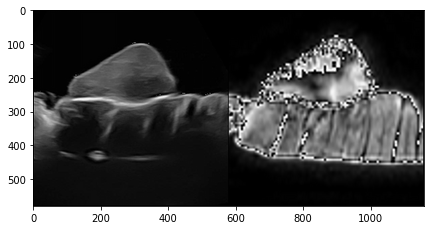

In [7]:
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=32)
us_noisy_np = pil_to_np(us_noisy_pil) #if 2D and a new axis at the first dimension
# print(us_noisy_pil.size)
# print(us_noisy_np.shape)
    
mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=32)
mr_noisy_np = pil_to_np(mr_noisy_pil)

# As we don't have ground truth
us_pil = us_noisy_pil
us_np = us_noisy_np

mr_pil = mr_noisy_pil
mr_np = mr_noisy_np

#compute sensor gain
# sensor_gain
us_sg, mr_sg = sensor_gain(us_np[0],mr_np[0],d=32)
print(us_sg)
print(mr_sg)
us_sg_np = us_sg[None,:] #numpy is [1,*,*] rather than [*,*]
mr_sg_np = mr_sg[None,:]
us_sg_torch = np_to_torch(us_sg_np).type(dtype).to(device = 'cuda')
mr_sg_torch = np_to_torch(mr_sg_np).type(dtype).to(device = 'cuda')


if PLOT:
    plot_image_grid([us_np,mr_np], 4, 5);

In [8]:
#Test
a = torch.randn(1,2,3)
b = torch.randn(1,2,3)
c = a * b #same as np.multiply()
print(a)
print(b)
print(c)
a = np.array([1,2,3,4]).reshape(2,2)
b = np.array([1,2,3,4]).reshape(2,2)
# print(np.dot(a,b))
# print(np.multiply(a,b))

c = np.append(a,b)
c = np.append(c,b)
c = np.array([0.3]*4)

b = np.ones(3)
a = np.random.rand(4,8)
m1 = np.dot(a,a.transpose())
m2 = np.zeros((4,4))

for i in range(a.shape[1]):
    temp_a = a[:,i][:,None]
    m2 += np.dot(temp_a, temp_a.transpose())  

tensor([[[-0.6196, -1.9920, -0.1095],
         [-0.9177, -0.2392, -0.8010]]])
tensor([[[-0.4009,  0.0665, -0.9105],
         [-0.7169,  1.3257, -0.4415]]])
tensor([[[ 0.2484, -0.1324,  0.0997],
         [ 0.6579, -0.3172,  0.3536]]])


# Setup For MR and US


In [9]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 2400
input_depth = 1
figsize = 5 

net = skip(
            input_depth, 1, 
            num_channels_down = [8, 16, 32, 64, 128], 
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [0, 0, 0, 4, 4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)

#net input is white noise
net_input = get_noise(input_depth, INPUT, (us_pil.size[1], us_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

us_noisy_torch = np_to_torch(us_noisy_np).type(dtype)
mr_noisy_torch = np_to_torch(mr_noisy_np).type(dtype)

Number of params: 572665


## Optimise for MR and US

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_r

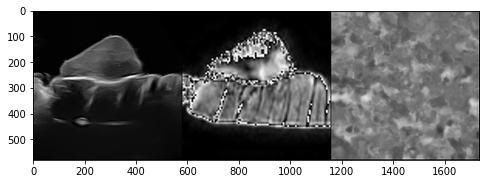

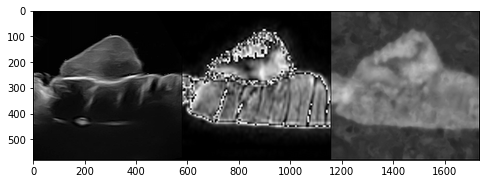

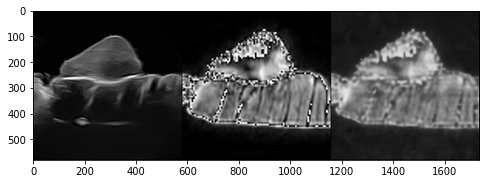

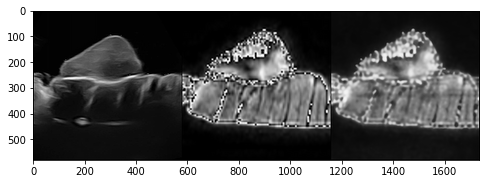

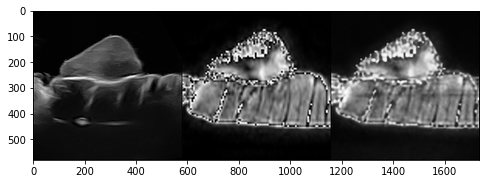

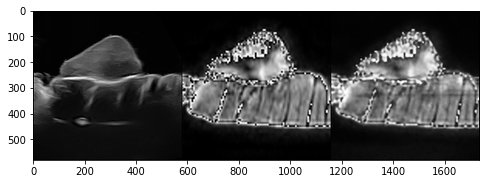

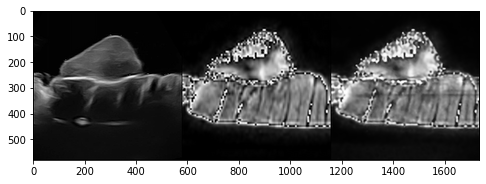

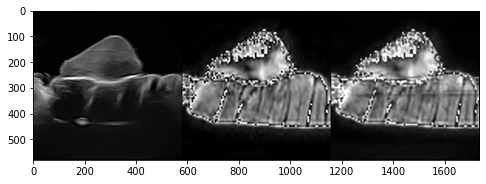

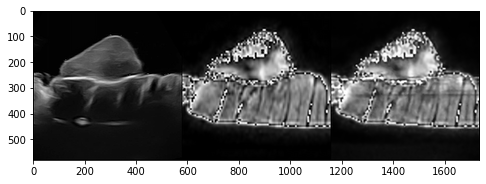

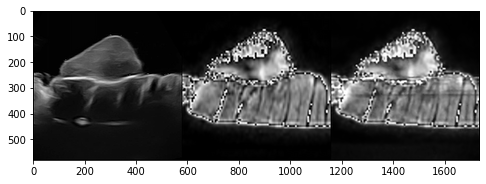

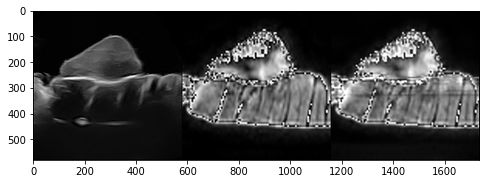

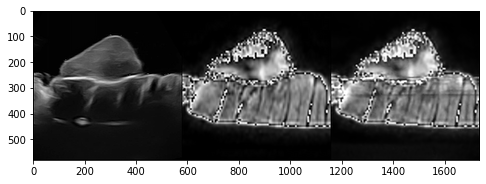

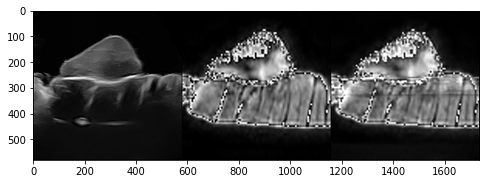

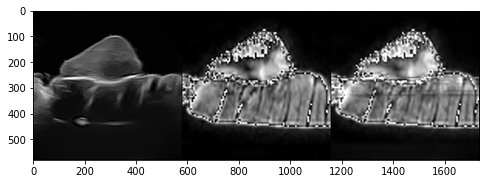

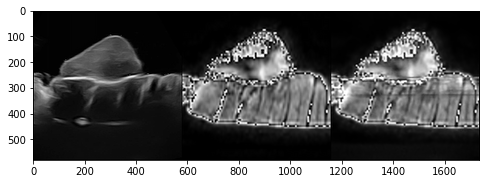

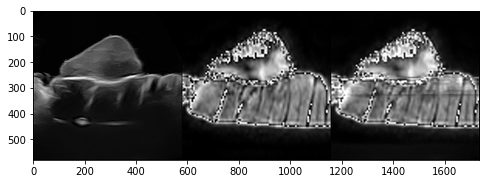

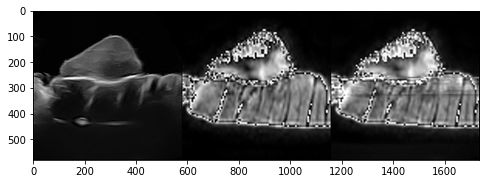

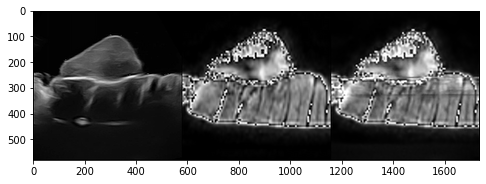

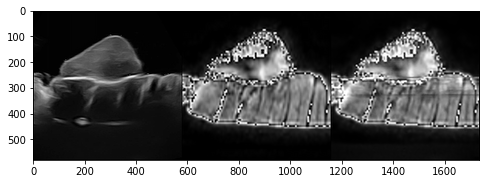

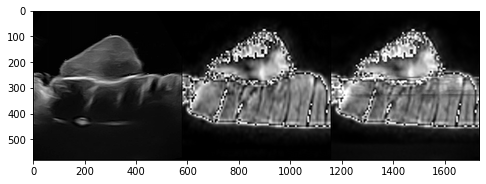

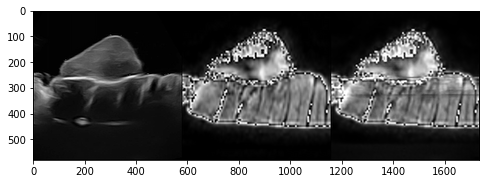

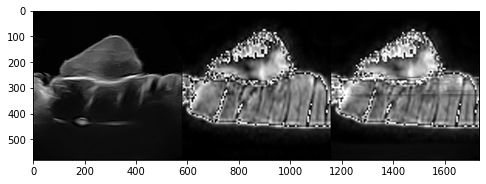

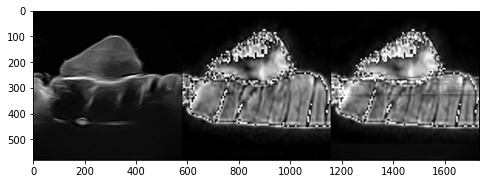

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
us_para = 0.5

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input

    #xudong avoid start from the previous running result
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)


    #linear combination of US and MR  mean square error  
    total_loss = us_para * mse(us_sg_torch * out, us_noisy_torch) + (1 - us_para) * mse(mr_sg_torch * out,mr_noisy_torch)
    # total_loss = mse(out, us_noisy_torch)
    total_loss.backward()
        
    
    ####only us image
    psrn_noisy = compare_psnr(us_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(us_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(us_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        # plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(out_np, 0, 1), 
        #                  np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
import inspect
# print(inspect.getsource(crop_image))
print(inspect.getsourcefile(crop_image))
print(inspect.getsourcefile(np_to_torch))


/content/utils/common_utils.py
/content/utils/common_utils.py


In [ ]:
out_np = torch_to_np(net(net_input))
# q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
#Test
a = abs(np.random.randn(2,2))
print(a)
b = np.square(a)
c = np.sqrt(b)
print(b)
print(c)


[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]
[[4.48903262 1.38034368]
 [0.36701177 0.53842659]]
[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]


In [56]:
import matlab.engine
import numpy as np
from utils.common_utils import *
size = 6

a = np.ones(size**2).reshape(size,size)
b = np.ones(size**2).reshape(size,size)
[sg1, sg2] = sensor_gain(a,b,2)

mat_a = matlab.double(a.tolist())
mat_b = matlab.double(b.tolist())

eng = matlab.engine.start_matlab()
beta = eng.SensorGain(mat_a,mat_b) #only return the first variable
print(sg1)
print(beta)


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475]]
